# Title

**Author:** Marina Kochuten

**Repository:** https://github.com/marinakochuten/phoenix-bii-change


## About

In 2021, Maricopa County —home to the Phoenix metropolitan area— was identified as the U.S. county with the most significant increase in developed land since 2001 [1]. This rapid urban sprawl has profound implications for biodiversity and the health of surrounding natural ecosystems.

In this notebook, I investigate the impacts of urban expansion by analyzing a dataset that captures values for the Biodiversity Intactness Index (BII) [2]. The Biodiversity Intactness Index (BII) measures biodiversity change using abundance data on plants, fungi and animals worldwide. The BII shows how local terrestrial biodiversity responds to human pressures such as land use change and intensification. (https://en.wikipedia.org/wiki/Measurement_of_biodiversity).

I examine changes in BII in the Phoenix county subdivision area between 2017 and 2020, shedding light on how urban growth affects biodiversity over time.


## Highlights

- 
- 
- 

## Data

**Biodiversity Intactness Index (BII) Time Series:** 

**Citation:**

**Phoenix Subdivision Shapefile:**

**Citation:** https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr

import pystac_client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog

from IPython.display import Image  # To nicely display images
import contextily as cx   # For basemap

pd.set_option("display.max.columns", None)

ModuleNotFoundError: No module named 'contextily'

## Access Data: BII Time Series

For the BII time series, I access the `io-biodiversity` collection from the Microsoft Planetary Computer STAC catalog and use the 2017 and 2020 rasters covering the Phoenix subdivision (bounding box coordinates:[-112.826843, 32.974108, -111.184387, 33.863574])

In [13]:
# Create bounding box for search
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]
bbox

[-112.826843, 32.974108, -111.184387, 33.863574]

In [14]:
# Open MPC data catalog (establish connection to API)
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Search MPC catalog
search = catalog.search(collections = ['io-biodiversity'],
                       bbox = bbox
                       )

# Retrive search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 4 Items


There are 4 items in my search, one raster for each year that I am interested in (2017 - 2020). 

## BII Time Series Exploration

First, I'll take a quick look at one of the pre-redered images from the catalog

In [15]:
# Select unique search items for 2020 and 2017
item2020 = items[0]
item2017 = items[3]

# Display a pre-rendered image
Image(url=item2020.assets['rendered_preview'].href, width=400)

Here, we have a raster showing biodiversity intactness in the Phoenix area. Darker green indicates higher intactness.

Let's dive a litter deeper by importing the rasters for 2017 and 2020. Down the line, I will compare changes between these two rasters to show BII changes from 2017 to 2020!

In [16]:
# Access raster data from items
bii_2020 = rioxr.open_rasterio(item2020.assets['data'].href)
bii_2017 = rioxr.open_rasterio(item2017.assets['data'].href)

# Let's look at the data for 2020
bii_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Notice that band is a dimension of length 1. We can go ahead and “squeeze” the raster to simplify it. I will do this for both my 2017 and my 2020 rasters:

In [17]:
# Remove length 1 dimension (band)
bii_2020 = bii_2020.squeeze().drop_vars('band')
bii_2017 = bii_2017.squeeze().drop_vars('band')

print("Sizes of dimensions, bii_2020:", dict(bii_2020.sizes))
print("Sizes of dimensions, bii_2017:", dict(bii_2017.sizes))

Sizes of dimensions, bii_2020: {'y': 7992, 'x': 7992}
Sizes of dimensions, bii_2017: {'y': 7992, 'x': 7992}


Lastly, I want to know the CRS of this data.

In [18]:
bii_2020.rio.crs

CRS.from_epsg(4326)

The CRS of my rasters is EPSG:4326! I will keep this in mind as I explore my next geospatial object, the Phoenix Subdivision shapefile.

## Access Data: Phoenix Subdivision Shapefile

In [6]:
# Read in the shapefile
arizona = gpd.read_file('data/tl_2022_04_cousub.shp')

## Phoenix Subdivision Shapefile exploration

In [7]:
# Look at the head of the data
arizona.head(3)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,None,None,None,S,12231052883,44653332,+35.1066114,-111.3662497,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,None,None,None,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,None,None,None,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."


<Axes: >

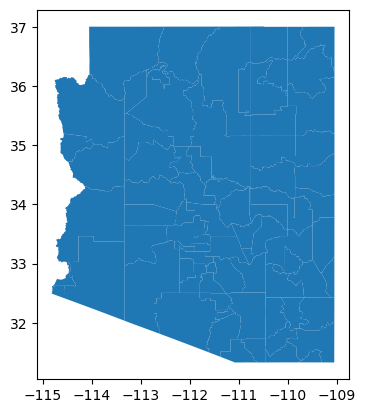

In [8]:
# Preliminary plot
arizona.plot()

The shapefile contains data for all of Arizona. Let's do a bit of processing to clean the column names and subset to Phoenix.

<Axes: >

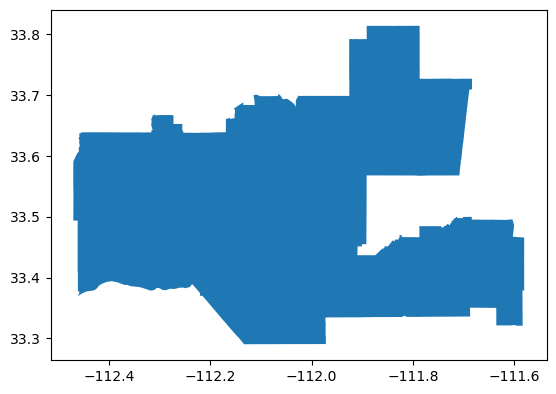

In [10]:
# Convert column names to lowercase
arizona.columns = arizona.columns.str.lower()

# Filter to Phoenix
phoenix = arizona[arizona.name == "Phoenix"]

# Preliminary plot
phoenix.plot()

In [11]:
# Check the CRS
phoenix.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

The CRS of this `GeoDataFrame` is EPSG:4269. Note that this is different from the BII rasters, and I will need to match them before they can interact. 

## Map the Phoenix subdivision

To contextualize the Phoenix subdivision within its broader geographic context, I will include a basemap from the `contextily` package. The simplest way to access `contextily` and get a background map to go with your geographic data is to use the `add_basemap` method. Because the method takes a `matplotlib` axis, it is easy to integrate contextily with any other package for geospatial data that plots to matplotlib, such as `rasterio` and `geopandas`.